In [1]:
import pandas as pd
import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy import interpolate


from matplotlib import rcParams, rc

# set rcParams ~~~~~~~~~~~~~~~~~~~~~~~~
rcParams['axes.linewidth'] =    2
rcParams['xtick.major.size'] =  6
rcParams['xtick.major.width'] = 2
rcParams['xtick.minor.size'] =  3
rcParams['xtick.minor.width'] = 2
rcParams['ytick.major.size'] =  6
rcParams['ytick.major.width'] = 2
rcParams['ytick.minor.size'] =  3
rcParams['ytick.minor.width'] = 2
font = {'size' : 16, 'weight' : 'bold'}
rc('font', **font)

In [2]:
def get_vlos(file, r_p, omega, level):
    colnames = ['lat', 'lon', 'level', 'alt', 'pres', 'temp',
                            'u', 'v', 'w',
                            'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                            'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                            'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                            'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                            'incident_frac']
    df = pd.read_csv(file, delim_whitespace=True, names=colnames, header=None)
    subobslon = 0
    dtr = 0.0174533 # Degrees to radians
    
    # I only care about some spots
    df = df[(df['level'] == level)].reset_index(drop=True)
    
    df['vlos'] =  -df.u * np.sin(subobslon - (df.lon * dtr)) + \
                df.v * np.cos(subobslon - (df.lon * dtr)) * np.sin(df.lat * dtr) - \
                omega * (r_p + df.alt) * np.sin(subobslon - (df.lon * dtr)) * np.cos(df.lat * dtr)
    
    df.to_csv('test.txt', index=False, sep=' ')
    X = list(df['lat'])
    Y = list(df['lon'])
    vlos = list(df['vlos'])
    temp = list(df['temp'])
    return X, Y, vlos, temp






def add_vlos(file, r_p, omega, inc):
    df = pd.read_csv(file + '.txt', delim_whitespace=True, names=('lat', 'lon', 'level',
                                                              'alt', 'pres', 'temp',
                                                              'u', 'v', 'w',
                                                              'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                                                              'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                                                              'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                                                              'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                                                              'incident_frac'))
    subobslon = 0
    dtr = 0.0174533 # Degrees to radians
    df['vlos'] =  -df.u * np.sin(subobslon - (df.lon * dtr)) + \
                df.v * np.cos(subobslon - (df.lon * dtr)) * np.sin(df.lat * dtr) - \
                np.cos(inc) * (omega * (r_p + df.alt) * np.sin(subobslon - (df.lon * dtr)) * np.cos(df.lat * dtr)) 

    np.savetxt(file + '_vlos.txt', df.to_numpy(),
    fmt='%12.4E %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E  %12.4E\t')

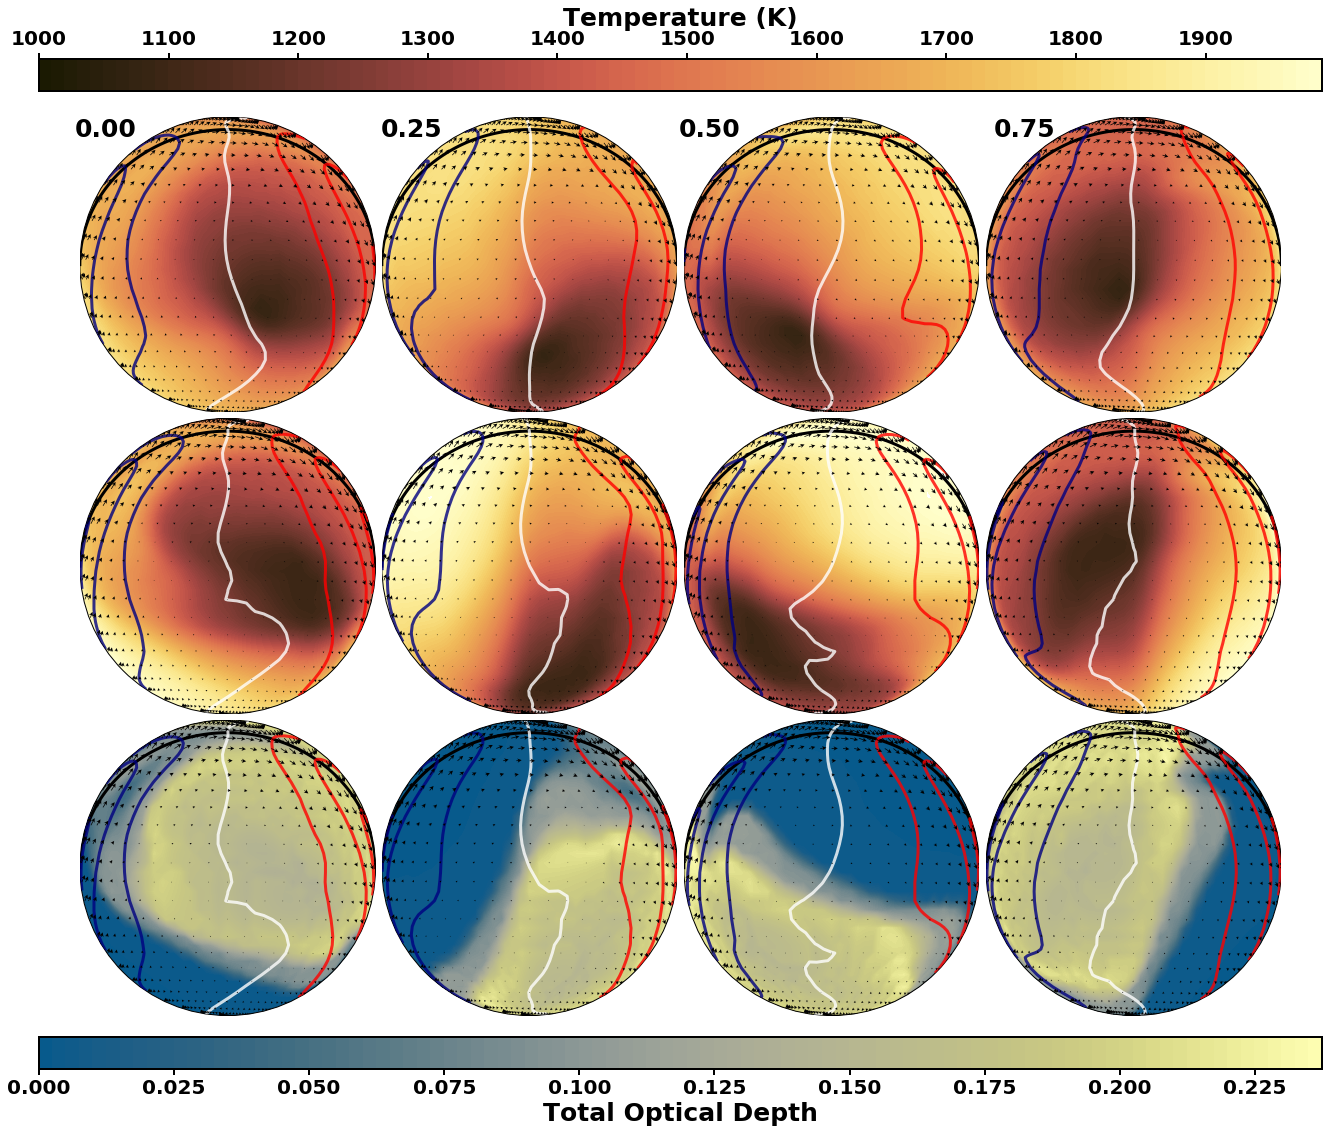

In [33]:
# colormap
cm_name = 'lajolla'
cm_file = np.loadtxt(f'ScientificColourMaps5/lajolla/lajolla.txt')
my_colors = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

# colormap
cm_name2 = 'nuuk'
cm_file2 = np.loadtxt(f'ScientificColourMaps5/nuuk/nuuk.txt')
my_colors2 = mcolors.LinearSegmentedColormap.from_list(cm_name2, cm_file2)

fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(23,24))
plt.subplots_adjust(wspace=-0.2, hspace=0.02)


files = ['/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_0.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_90.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_180.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_270.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_0.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_90.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_180.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_270.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_0.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_90.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_180.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_270.0_inc_1.152']

pressure_mins = [79.8] * len(files)

i = 0
z = 0
for file in files:
    pressure_min = pressure_mins[i]
    r_p = 6.99e7
    omega = 2.063e-5
    inc = 1.152


    add_vlos(file, r_p, omega, inc)
    df = pd.read_table(file + '_vlos.txt',
                        delim_whitespace=True,
                        names=('lat', 'lon', 'level',
                                'alt', 'pressure', 'temp',
                                'u', 'v', 'w',
                                'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                                'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                                'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                                'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                                'incident_frac','vlos'))

    all_lats = sorted(list(set(df.lat)))
    all_lons = sorted(list(set(df.lon)))
    
    lats = []
    lons = []
    temps = []
    us = []
    vs = []
    vloss = []
    taus = []

    for lat in all_lats:
        for lon in all_lons:
            temp_df = df[df.lat == lat]
            temp_df = temp_df[temp_df.lon == lon]
            temp_df = temp_df.reset_index()

            tau = 0
            k = 0 
            while temp_df.pressure[k] * 1e-2 < pressure_min:
                tau += temp_df.aero_sw_tau_1[k] * (0.07 / 0.01) * 0.2 
                tau += temp_df.aero_sw_tau_2[k] * (1.25 / 0.16) * 0.2
                tau += temp_df.aero_sw_tau_3[k] * (0.12 / 0.02) * 0.2
                tau += temp_df.aero_sw_tau_4[k] * (0.56 / 0.02) * 0.2
            
                k = k + 1

            lats.append(lat)
            lons.append(lon)
            temps.append(temp_df.temp[k])
            vloss.append(temp_df.vlos[k])
            us.append(temp_df.u[k])
            vs.append(temp_df.v[k])
            taus.append(tau)
            

    new_lats = np.reshape(lats, (48, 96))
    new_lons = np.reshape(lons, (48, 96))

    final_lats = new_lats * np.pi / 180
    final_lons = new_lons * np.pi / 180
    
    final_taus  = np.reshape(taus, (48, 96))
    final_temps = np.reshape(temps, (48, 96))

    final_us = np.reshape(us, (48, 96))
    final_vs = np.reshape(vs, (48, 96))
    final_vlos = np.reshape(vloss, (48, 96))       

    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax[i//4, i%4])

    # compute native map projection coordinates of lat/lon grid.
    x, y = map(final_lons*180./np.pi, final_lats*180./np.pi)

    
    # Graph temperature
    if i//4 != 2:
        cs1 = map.contourf(x, y, final_temps, 100, cmap=my_colors, levels=np.arange(1000, 2000, 10))
    else:
        cs2 = map.contourf(x, y, final_taus, 100, cmap=my_colors2)


    map.contour(x, y, final_vlos, levels=[0],colors='white', linewidths=3,zorder=3, alpha=0.8)

    map.contour(x, y, final_vlos, levels=[-4000, -3000, -2000, -1000], colors='red', alpha=0.8,
                linewidths=3, linestyles='solid',zorder=3)

    map.contour(x, y, final_vlos, levels=[1000, 2000, 3000, 4000],  alpha=0.8,
                                  colors='navy', linewidths=3,zorder=5)

    map.drawgreatcircle(-90, 0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=1)
    map.drawgreatcircle(90,  0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=2)

    # Graph the wind vectors
    map.quiver(x[::2,::2], y[::2,::2], final_us[::2,::2], final_vs[::2,::2], color='black',
              headwidth=6, scale = 220000, headlength=6, alpha=1.0, zorder=6) 
    
    i = i + 1


cbar1 = fig.colorbar(cs1, ax=ax.ravel().tolist(), location='top', aspect=40, pad=0.02)
cbar2 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=40, pad=0.02)

cbar1.outline.set_linewidth(2)
cbar1.set_label(label='Temperature (K)',weight='bold', fontsize=25)
cbar1.ax.tick_params(labelsize=20) 

cbar2.outline.set_linewidth(2)
cbar2.set_label(label='Total Optical Depth',weight='bold', fontsize=25)
cbar2.ax.tick_params(labelsize=20) 

fig.text(0.165, 0.74, r"0.00", size=25, weight='bold', ha='center')
fig.text(0.35, 0.74, r"0.25", size=25, weight='bold', ha='center')
fig.text(0.53, 0.74, r"0.50", size=25, weight='bold', ha='center')
fig.text(0.72, 0.74, r"0.75", size=25, weight='bold', ha='center')

plt.savefig('/home/imalsky/Desktop/hemis.png', bbox_inches='tight', dpi=250)
    

/home/imalsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: No contour levels were found within the data range.
/home/imalsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: No contour levels were found within the data range.
/home/imalsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: No contour levels were found within the data range.
/home/imalsky/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:144: UserWarning: No contour levels were found within the data range.


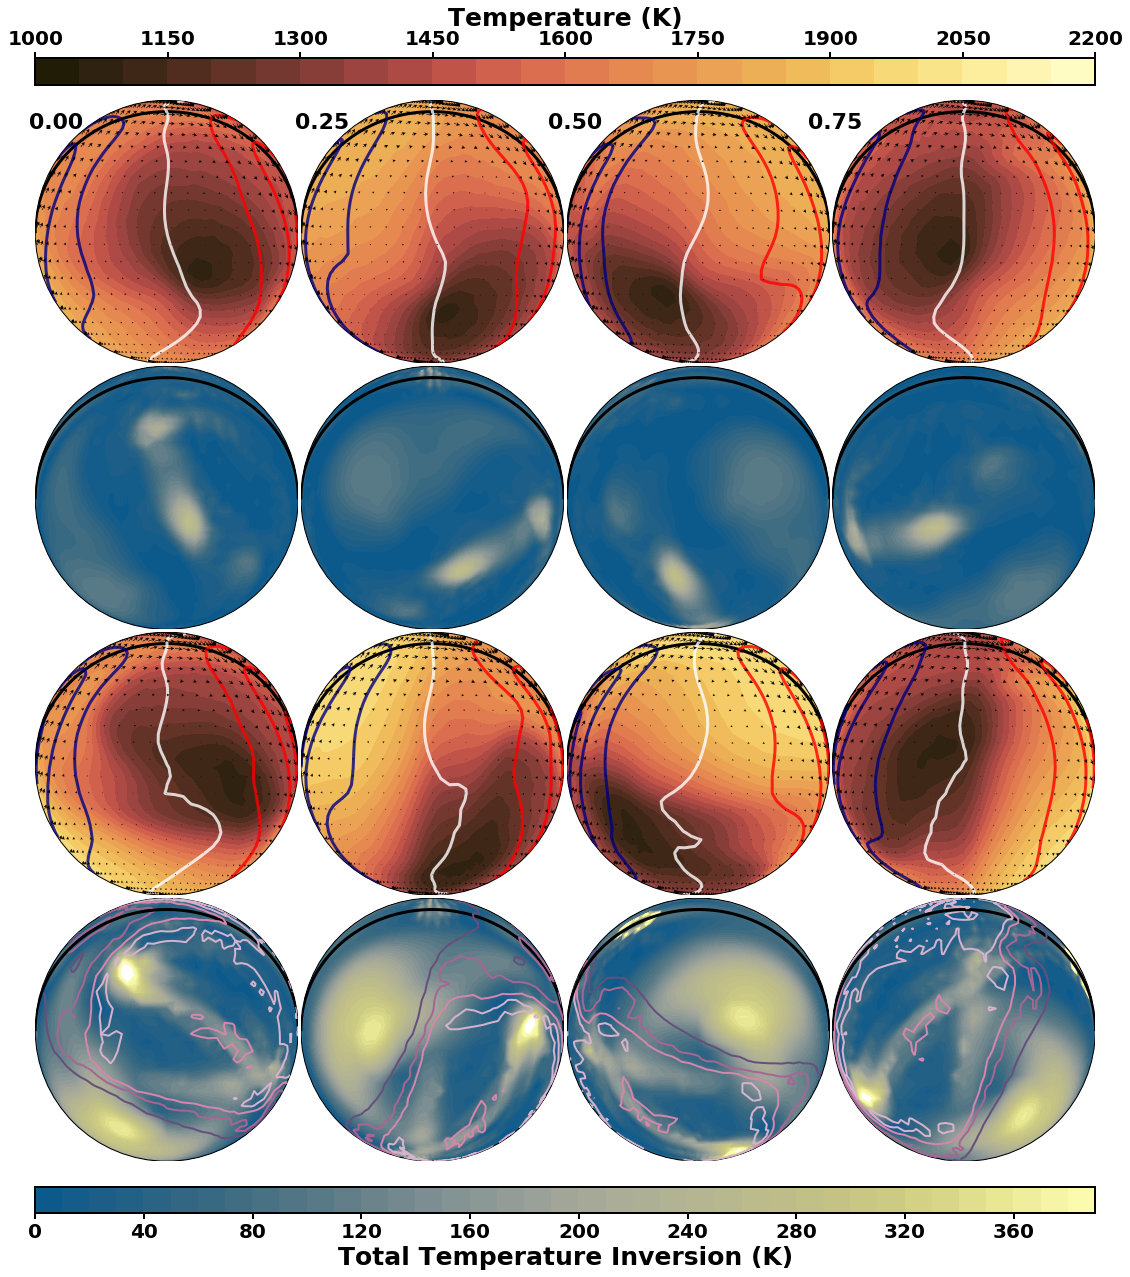

In [98]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(19,28))
plt.subplots_adjust(wspace=0.01, hspace=0.01)


# colormap
cm_name = 'lajolla'
cm_file = np.loadtxt(f'ScientificColourMaps5/lajolla/lajolla.txt')
my_colors1 = mcolors.LinearSegmentedColormap.from_list(cm_name, cm_file[::-1])

# colormap
cm_name2 = 'nuuk'
cm_file2 = np.loadtxt(f'ScientificColourMaps5/nuuk/nuuk.txt')
my_colors2 = mcolors.LinearSegmentedColormap.from_list(cm_name2, cm_file2)

# colormap
cm_name3 = 'acton'
cm_file3 = np.loadtxt('ScientificColourMaps5/{}/{}.txt'.format(cm_name3, cm_name3))
my_colors3 = mcolors.LinearSegmentedColormap.from_list(cm_name3, cm_file3)


files = ['/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_0.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_90.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_180.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLEAR-250_phase_270.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_0.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_90.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_180.0_inc_1.152',
         '/media/imalsky/fafsadf/big-init-files/init_UPS-LOW-G-CLOUDY-250_phase_270.0_inc_1.152']

pressure_mins = [79.8] * len(files)

i = 0
z = 0
for file in files:
    pressure_min = pressure_mins[i]
    r_p = 6.99e7
    omega = 2.063e-5
    inc = 1.152


    add_vlos(file, r_p, omega, inc)
    df = pd.read_table(file + '_vlos.txt',
                        delim_whitespace=True,
                        names=('lat', 'lon', 'level',
                                'alt', 'pressure', 'temp',
                                'u', 'v', 'w',
                                'aero_sw_tau_1', 'sw_asym_1', 'sw_pi0_1',
                                'aero_sw_tau_2', 'sw_asym_2', 'sw_pi0_2',
                                'aero_sw_tau_3', 'sw_asym_3', 'sw_pi0_3',
                                'aero_sw_tau_4', 'sw_asym_4', 'sw_pi0_4',
                                'incident_frac','vlos'))

    all_lats = sorted(list(set(df.lat)))
    all_lons = sorted(list(set(df.lon)))
    
    lats = []
    lons = []
    temps = []
    us = []
    vs = []
    vloss = []
    taus = []
    
    temp_inversions = []

    for lat in all_lats:
        for lon in all_lons:
            temp_df = df[df.lat == lat]
            temp_df = temp_df[temp_df.lon == lon]
            temp_df = temp_df.reset_index()

            tau = 0
            k = 0 
            while temp_df.pressure[k] * 1e-2 < pressure_min:
                tau += temp_df.aero_sw_tau_1[k] * (0.07 / 0.01) * 0.2 
                tau += temp_df.aero_sw_tau_2[k] * (1.25 / 0.16) * 0.2
                tau += temp_df.aero_sw_tau_3[k] * (0.12 / 0.02) * 0.2
                tau += temp_df.aero_sw_tau_4[k] * (0.56 / 0.02) * 0.2
                k = k + 1
            
            lats.append(lat)
            lons.append(lon)
            temps.append(temp_df.temp[k])
            vloss.append(temp_df.vlos[k])
            us.append(temp_df.u[k])
            vs.append(temp_df.v[k])
            taus.append(tau)
            
            
            # Get the temperature inverson
            max_dT = 0      # max temo inversion at this lat/lon
            current_dT = 0  # keep track of current continuous temp inversion

            for k in reversed(range(250 - 1)):
                if temp_df.temp[k] > 0 and temp_df.temp[k+1] > 0:
                    # check if delta T is postive
                    if temp_df.temp[k] > temp_df.temp[k + 1]:
                        # if delta T is positive, add it to the current continuous dT
                        dT = temp_df.temp[k] - temp_df.temp[k + 1]
                        current_dT += dT
                        # if the current dT is greater than the max dT, then it becomes the new max dT
                        if current_dT > max_dT:
                            max_dT = current_dT
                    # if delta T is negative, reset the current continuous dT
                    else:
                        current_dT = 0
                

            temp_inversions.append(max_dT)


            
    new_lats = np.reshape(lats, (48, 96))
    new_lons = np.reshape(lons, (48, 96))

    final_lats = new_lats * np.pi / 180
    final_lons = new_lons * np.pi / 180
    
    final_taus  = np.reshape(taus, (48, 96))
    final_temps = np.reshape(temps, (48, 96))
    
    final_inversions = np.reshape(temp_inversions, (48, 96))

    final_us = np.reshape(us, (48, 96))
    final_vs = np.reshape(vs, (48, 96))
    final_vlos = np.reshape(vloss, (48, 96))       


    # compute native map projection coordinates of lat/lon grid.
    x, y = map(final_lons*180./np.pi, final_lats*180./np.pi)
    
    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax[2 * (i//4), i%4])
    cs1 = map.contourf(x, y, final_temps, cmap=my_colors1, levels=np.arange(1000, 2250, 50))
    map.contour(x, y, final_vlos, levels=[0],colors='white', linewidths=3,zorder=3, alpha=0.8)
    map.contour(x, y, final_vlos, levels=[-4000, -3000, -2000, -1000], colors='red', alpha=0.8,linewidths=3, linestyles='solid',zorder=3)
    map.contour(x, y, final_vlos, levels=[1000, 2000, 3000, 4000],  alpha=0.8,colors='navy', linewidths=3,zorder=5)
    map.drawgreatcircle(-90, 0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=1)
    map.drawgreatcircle(90,  0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=2)
    map.quiver(x[::2,::2], y[::2,::2], final_us[::2,::2], final_vs[::2,::2], color='black',headwidth=6, scale = 220000, headlength=6, alpha=1.0, zorder=6) 
    
    
    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax[1 + 2 * (i//4), i%4])
    cs2 = map.contourf(x, y, final_inversions, cmap=my_colors2, levels=np.arange(0, 400, 10))
    cs3 = map.contour(x, y, final_taus, levels=[0.0, 0.05, 0.10, 0.15, 0.20, 0.25], cmap=my_colors3, linewidths=2)
    map.drawgreatcircle(-90, 0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=1)
    map.drawgreatcircle(90,  0, 180, 66, linewidth=3, color='black', linestyle='solid', zorder=2)
    i = i + 1


cbar1 = fig.colorbar(cs1, ax=ax.ravel().tolist(), location='top', aspect=40, pad=0.01)
cbar2 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=40, pad=0.02)

cbar1.outline.set_linewidth(2)
cbar1.set_label(label='Temperature (K)',weight='bold', fontsize=25)
cbar1.ax.tick_params(labelsize=20) 

cbar2.outline.set_linewidth(2)
cbar2.set_label(label='Total Temperature Inversion (K)',weight='bold', fontsize=25)
cbar2.ax.tick_params(labelsize=20) 

fig.text(0.14, 0.745, r"0.00", size=22, weight='bold', ha='center')
fig.text(0.335, 0.745, r"0.25", size=22, weight='bold', ha='center')
fig.text(0.52, 0.745, r"0.50", size=22, weight='bold', ha='center')
fig.text(0.71, 0.745, r"0.75", size=22, weight='bold', ha='center')

plt.savefig('/home/imalsky/Desktop/hemis.png', bbox_inches='tight', dpi=250)
    

'\ncbar1.outline.set_linewidth(2)\ncbar1.set_label(label=\'Temperature (K)\',weight=\'bold\', fontsize=25)\ncbar1.ax.tick_params(labelsize=20) \n\ncbar2.outline.set_linewidth(2)\ncbar2.set_label(label=\'Total Temperature Inversion\',weight=\'bold\', fontsize=25)\ncbar2.ax.tick_params(labelsize=20) \n\n\nfig.text(0.14, 0.745, r"0.00", size=22, weight=\'bold\', ha=\'center\')\nfig.text(0.335, 0.745, r"0.25", size=22, weight=\'bold\', ha=\'center\')\nfig.text(0.52, 0.745, r"0.50", size=22, weight=\'bold\', ha=\'center\')\nfig.text(0.71, 0.745, r"0.75", size=22, weight=\'bold\', ha=\'center\')\n'

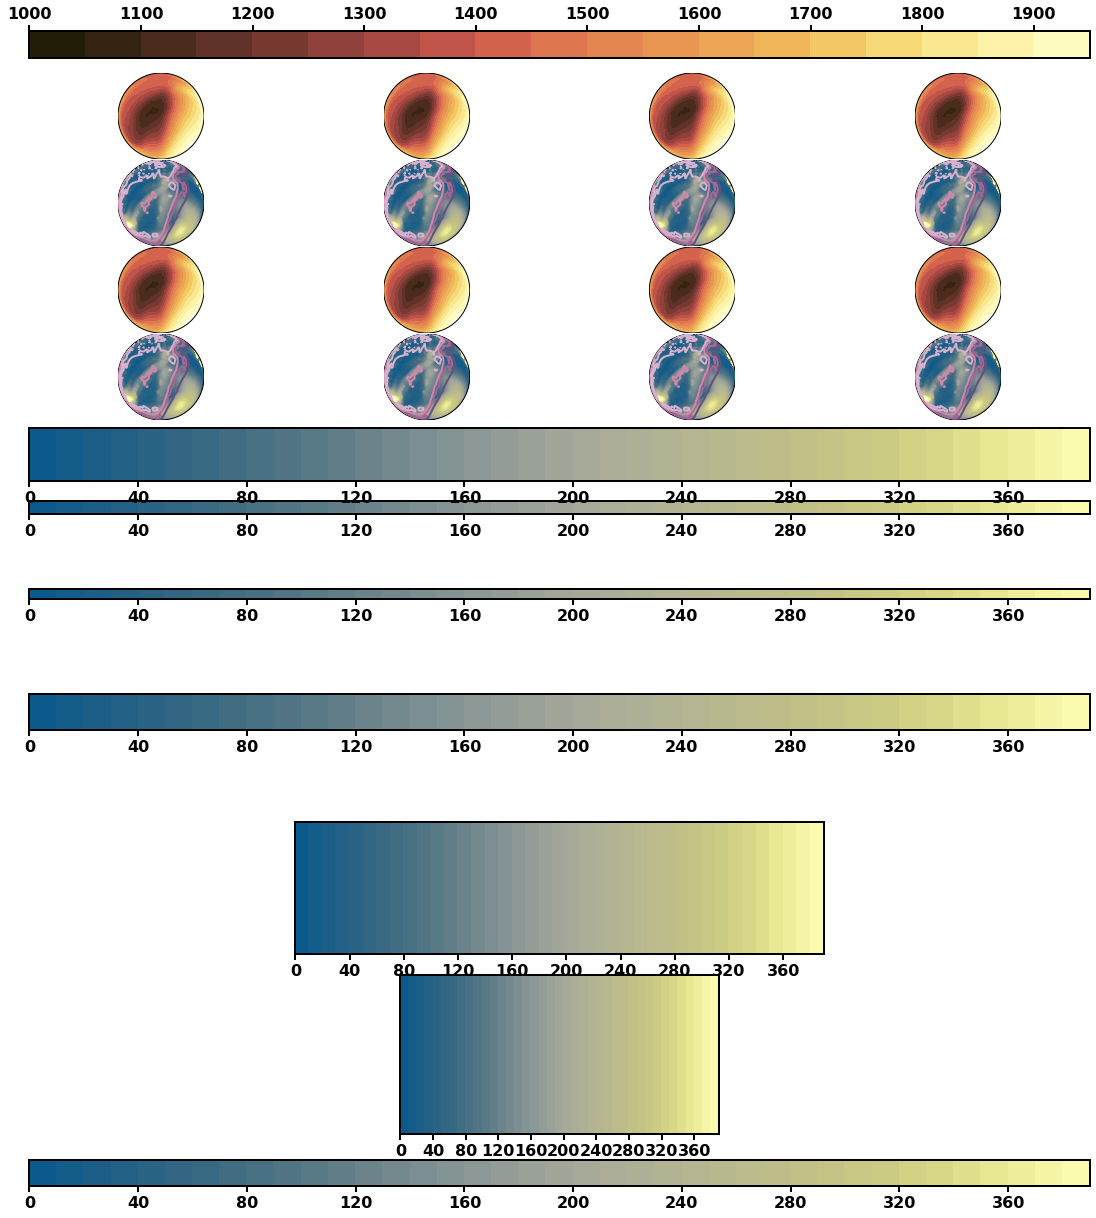

In [97]:

# colormap
cm_name3 = 'acton'
cm_file3 = np.loadtxt('ScientificColourMaps5/{}/{}.txt'.format(cm_name3, cm_name3))
my_colors3 = mcolors.LinearSegmentedColormap.from_list(cm_name3, cm_file3)

fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(19,28))
plt.subplots_adjust(wspace=0.01, hspace=0.01)

for i in range(8):
    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax[2 * (i//4), i%4])
    cs1 = map.contourf(x, y, final_temps, cmap=my_colors1, levels=np.arange(1000, 2000, 50))

    map = Basemap(projection='ortho',lat_0=0,lon_0=180,resolution='l', ax=ax[1 + 2 * (i//4), i%4])
    cs2 = map.contourf(x, y, final_inversions, cmap=my_colors2, levels=np.arange(0, 400, 10))
    cs3 = map.contour(x, y, final_taus, levels=[0.0, 0.05, 0.10, 0.15, 0.20, 0.25], cmap=my_colors3, linewidths=2)
    
cbar1 = fig.colorbar(cs1, ax=ax.ravel().tolist(), location='top', aspect=40, pad=0.01)
cbar2 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=40, pad=0.02)
cbar3 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=2, pad=0.02)
cbar4 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=4, pad=0.02)
cbar5 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=30, pad=0.02)
cbar6 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=100, pad=0.02)
cbar7 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=80, pad=0.02)
cbar8 = fig.colorbar(cs2, ax=ax.ravel().tolist(), location='bottom', aspect=20, pad=0.02)


"""
cbar1.outline.set_linewidth(2)
cbar1.set_label(label='Temperature (K)',weight='bold', fontsize=25)
cbar1.ax.tick_params(labelsize=20) 

cbar2.outline.set_linewidth(2)
cbar2.set_label(label='Total Temperature Inversion',weight='bold', fontsize=25)
cbar2.ax.tick_params(labelsize=20) 


fig.text(0.14, 0.745, r"0.00", size=22, weight='bold', ha='center')
fig.text(0.335, 0.745, r"0.25", size=22, weight='bold', ha='center')
fig.text(0.52, 0.745, r"0.50", size=22, weight='bold', ha='center')
fig.text(0.71, 0.745, r"0.75", size=22, weight='bold', ha='center')
"""